# Documentation for Hydra Multi-Asset Verification Test

## Trade sizes random but 2 * q to r direction due to initial price
## All 3 trades in both assets
## add at time 10, remove at time 490
## mu = 3
## 10 a values from 0.9 to 1.1

ACTION_LIST = [['test_add', 'test_q_for_r', 'test_r_for_r','test_r_for_q', 'test_remove']]



## Model Description

The methodology for the tests is to create two universes - one for Hydra and one for Uniswap - to subsequently be able to represent sequences of actions on each side. As the Hydra system is unique in its design and has no counterpart yet for approprate comparisons the role of the benchmark will be fulfilled by assembling several Uniswaps together in a way that everything that can be done in Hydra can be accordingly reproduced. This allows next to compare the implications on both systems and ultimately assess the quantitative and qualitative differences of results and impacts on the Hydra system and its agents. 

This approach necessitates the definition and specification of two models:
   - 1 Hydra Omnipool model with one instance that is defined in line with the [Hydra Mathematical Specification](https://hackmd.io/M7OeWimITKGVxBDHGQa6gQ?view)
   - 1 Uniswap model with several instances that each are responsible for a particular mechanism
        - which of 1 instance is used for liquidity provision in asset $R_i$: this is modeled as a Uniswap of $R_i$ and $Q$
        - which of 1 instance is used for liquidity provision in asset $R_j$: this is modeled as a Uniswap of $R_j$ and $Q$
        - which of 1 instance is used for swaps between assets $R_i$ and $R_j$: this is modeled as a Uniswap of $R_i$ and $R_j$
        
![](https://i.imgur.com/yb6Zh3T.png)
        
## Test cases

A variety of testcases can be explored with this model resulting from a combination of the following parameters
   
   - Event: Add Liquidity, Remove Liquidity, Swap Asset, Swap Asset for Base
   - Asset: $R_i$, $R_j$, $R_k$, $Q$
   - Multiple Action Type: Alternating, $i$ only, $j$ only
   - Composite Action Type: Alternating, Trade Bias
   - Enable Symmetric Liquidity: True, False
    
In addition to these settings also a fee structure can be imposed:

   - Fixed Fee

## Test agents

The model specifies a number of eight agents that each have their local balances, can interact with the system and are modeled to be responsible for **one action only**. This allows to track for each testcase how the balances will develop and to show independently which events will trigger changes to local and global states. Most importantly directly and indirectly affected variables can be easily identified.

Two dataframes of agents are initialized identically for both the Uniswap and the Hydra world and then work their way through on each side according to the testcase. Afterwards the effects on both sides can be compared.

![](https://i.imgur.com/r9IAJMr.png)



## Composite Action Tests

Besides being able to test all mechanisms individually also compositions of actions can be performed. This means selecting and combining two from the above testcases and letting the respective agents take the actions repeadetly. A composition action test therefore is defined as two actions which each can be a combination of *event* and *asset* selected from the list of testcases above, for example:
- Add liquidity in $R_i$ and Add liquidity in $R_j$
- Add liquidity in $R_i$ and Swap $R_i$ for $Q$
- Remove liquidity in $R_j$ and Swap $R_i$ for $Q$
- ...

In total there would be 28 composit pairs which can be derived from this decision tree:
selecting any one of the four primitive mechanisms of: **trade in/out** or **add/remove liquidity** of some given asset and then the subsequent action could be the three remaining mechanisms of the same asset or doing anyone of the four mechanisms in another asset.  

These basic combinations can be explored before further proceeding with
- trade sizes,
- trade frequencies,
- randomization,...



## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap (https://github.com/Uniswap/uniswap-v1/blob/master/contracts/uniswap_exchange.vy):
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

## Introduction to Hydra
>Hydra is an automated market maker that generalizes the concept of Uniswap and Balancer to a) an arbitrary number of dimensions and b) a variant weight distaribution of assets in the pool that changes in accordance with action sequences in the pool. Anyone can become a liquidity provider, and invest in the 'Omnipool'. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://hydradx.io/

There is a predefined set of (_mechanisms_) in which an agent can interact with an the Hydra Protocol :
1. `addLiquidity`: deposit a risk asset in the omnipool; mint HDX tokens - "shares" of this risk asset - in exchange;
1. `removeLiquidity`: burn HDX tokens; withdraw a proportional amount of the risk asset in exchange;
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" 
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Hydra takes the corresponding amount of "token A" from the user account 



## Model File structure

The folder **model** contains:

 - a file config.py: 

    This file configures the simulation experiments by setting the number of monte carlo runs, the number of timesteps for the simulation and the simulation parameters. It also aggregates the partial states and the initial state variables.
    
    The purpose of this file is to *configure and initialize* the experiment.
    
    
 - a file partial_state_update_block.py

    This file defines each partial state update block individually. This feature allows cadCAD to divide each simulation timestep into several 'blocks' where different state variables are mutated conditioned upon the policy input.
    
    In the current setting 
    - the first block maps the user action to the appropriate mechanism in the uniswap world
    - the second block maps the user action to the appropriate mechanism in the hydra world
    - the third block resolves the quantities of HDX and weights in the hydra world
    - the forth block calculates the metrics: the swap prices in the uniswap world and the pool prices in the hydra world

    This file corresponds to the system specification diagram, where each column is one partial state update block 
    
    The purpose of this file is to *define* the sequence and details of state updates for each simulation timestep. The relevant mechanisms are imported from the files in the **parts** folder
    
    
 - a file plot_utils.py

    This file defines all plot functions that can be called in the jupyter notebook to visualize the results. In general there are three types of plots:
    - plots related to the uniswap world (do not contain the word 'hydra')
    - plots related to the hydra world (contain the word 'hydra')
    - general plots applicable to both worlds (f.e Impermanent Loss)

    It also can be distinguished between plots related to global system variables and local agent variables:
    - global variables (do not contain the word 'agent')
    - local variables (contain the word 'agent')

    The purpose of this file is to *define* the way how particular properties can be plotted over time.
    

 - a file run.py

    This file *defines* the run and postprocessing methods and is used to execute the simulation run:
    - run() is used to execute the simulation and create a dataframe
    - postprocessing is used to extract relevant metrics from the simulation output in the dataframe

     The purpose of this file is to *execute* the simulation and *create* metrics.
     
     
 - a file state_variables.py

    This file *sets* the number of agents and *defines* the local (agent-level) state variables, *sets* the number of assets and *defines* the global (system-state) variables of the system, *computes* the prices of the assets and *defines* the initial state object
    - the agent states describe their holdings of assets that agents have contributed to the pool or still hold outside as well as their quantities of shares they received for their contribution
    - the global states describe the quantities of assets in the system
    - price variables are computed from the states both in the uniswap and hydra world
    - the initial state object consists of 
        - two agent dataframes, one for each world respectively
        - two sets of global variables, one for each world respectively
        - prices for each world (? is pool = prices ?)

    The purpose of this file is to *define* the global and local states of the system.
    
    
 - a file sys_params.py

    This file *contains* the system parameters and allows to select items from a list for them. Following parameters can be defined:
    - trade action type
    - liquidity action type
    - multiple asset action type
    - composite action type
    - liquidity add type (symmetry)

    In addition the following is set
    - initial values for assets 
    - hard coded fee value
    - choice of the system parameters from the list above
    

 - a folder **parts** which itself contains general files relevant for both instances, files related specifically to Uniswap and files related specifically to Hydra 
      - [action.py](model/parts/action.py)
       This is an action dictionary which drives the model. As there are no behavioral assumptions in the model yet, currently actions are prescribed actions in testing mode derived from events. However, action schema respects https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange as much as possible, allowing for future analysis against uniswap transaction datasets.
        This file contains a function called 'actionDecoder' which takes its inputs from the file sys_params.py and maps those encoded events to agent actions. At first an arbitrary action dictionary is defined which then is adapted according to the choices of system parameters. In particular relevant are the parameter definitions of the asset, the composite and whether there is a trade or liquidity event defined.
        
    - [uniswap.py](model/parts/uniswap.py)
     Reads in action output and directs the action to the appropriate Uniswap mechanism for each corresponding Uniswap instance. Currently there are two instances in place, namely the R_i<>Q pair and the R_j<>Q pair. Both instances have their respective requisite state variables: UNI_Qx, UNI_Rx, and UNI_Sx.

    - [utils.py](model/parts/utils.py)
    Computes the state update for each Uniswap state variable and outputs the updated global state variables.
        
     - [agent_utils.py](model/parts/agent_utils.py)
     Computes the corresponding agent local state for each Uniswap agent resolving their action and outputs the updates local state variables.

      -  [hydra.py](model/prts/hydra.py)
     Reads in action output and directs the action to the appropriate Hydra mechanism for each state variable: Q, Sq, and pool.
    
      - [hydra_utils.py](model/parts/hydra_utils.py)
     Computes the state update for each Hydra state variable

    -  [asset_utils.py](model/parts/asset_utils.py)
     Computes the state update for each Reserve Asset in a Hydra Omnipool

    -  [hydra_agent_utils_class.py](model/parts/hydra_agent_utils_class.py)
     Computes the corresponding agent local state for each Hydra agent resolving their action and outputs the updates local state variables.
     
     #### The interrelations between the files are shown here:
     
    ![](https://i.imgur.com/mNhfQE4.png)



# Testcase Definition

#### Simulation Settings
- There are 100 timesteps for each simulation run
- Each testcase has 100 MC runs with different randomized variables
- Block 1 randomizes starting liquidity balances (explained below in section 'Block 1')



#### Agent Activities - Action Sequence

There are two agents acting during the simulation. The trading agent performs "R-for-R" trades of equal size but varying direction over most simulation timesteps. The liquidity agent provides liquidity to the pool at timestep 10 and removes the liquidity from the pool at timestep 90.

##### Trading agent

- One Agent performs random "R-for-R" trades during the simulation. 
- The direction of the trade is a random coin flip for each timestep.
- The size of the trade is fixed at $1000$ for each timestep.
- The agent does not act at timestep 10 nor timestep 90.

##### Liquidity agent

- One Agent provides liquidity in Asset "i" to the pool 
- He provides the liquidity at timestep 10
- He removes the liquidity at timestep 90
- He does not act at other timesteps

#### Block 1:

| #   |   Run   | a  | $\mu_i$ |          $\sigma_i$          | $\mu_j$ |          $\sigma_j$          | $\mu$ | $\sigma$ | Total runs         |
| --- |:-------:|:-------:|:-------:|:----------------------------:|:-------:|:----------------------------:| ----- | -------- | ------------------ |
| 1   | 001-100 |   0.5   |   $100.000$   | $\frac{\mu_i}{\sigma_i}= 2$  |   $100.000$   | $\frac{\mu_j}{\sigma_j}= 2$  | $1.000$ | $0$      | $100$ |
| 2   | 101-200 |   0.5   |   $100.000$   | $\frac{\mu_i}{\sigma_i}= 50$ |   $100.000$   | $\frac{\mu_j}{\sigma_j}= 50$ | $1.000$ | $0$      | $100$ |
| 3   | 201-300 |    1    |   $100.000$   | $\frac{\mu_i}{\sigma_i}= 2$  |   $100.000$   | $\frac{\mu_j}{\sigma_j}= 2$  | $1.000$ | $0$      | $100$ |
| 4   | 301-400 |    1    |   $100.000$   | $\frac{\mu_i}{\sigma_i}= 50$ |   $100.000$  | $\frac{\mu_j}{\sigma_j}= 50$ | $1.000$ | $0$      | $100$ |
| 5   | 401-500 |   1.5   |   $100.000$   | $\frac{\mu_i}{\sigma_i}= 2$  |   $100.000$   | $\frac{\mu_j}{\sigma_j}= 2$  | $1.000$ | $0$      | $100$ |
| 6   | 501-600 |   1.5   |   $100.000$   | $\frac{\mu_i}{\sigma_i}= 50$ |   $100.000$   | $\frac{\mu_j}{\sigma_j}= 50$ | $1.000$ | $0$      | $100$ |

All tests in block 1 are performed as 100 **MonteCarlo Experiments** with the following randomization:
- The initial balances of the liquidity pools are drawn randomly for each MC run from the same lognormal distribution with $\mu_i$ and $\mu_j$ fixed at $100000$
    - The underlying mean for the lognormal liquidity draw is $\log{100000}$
    - The underlying standard deviation for the lognormal liquidity draw is $\sqrt{\log{1 + \frac{2000^2}{100000^2}}}$
- The action sequence of the agents is randomized in that sense that:
    - For each individual MC run the sequence is identical for the Uniswap and Hydra side of the model. For each timestep of the simulation exactly the same event takes place on both sides.
    - For each individual MC run the trading directions are randomized for each timestep. Therefore the event sequence for each run will be different.
    - For all MC runs the trading amount is always equal to $1000$




# Testcase in this notebook


This notebook documents the results of the following experiment:
- Settings from Block 1 as outlined above
- Testcases **2**, **4** and **6**
- Sweep over three values for $a \in \{0.5, 1, 1.5 \}$ with a fixed $\mu$-to-$\sigma$-ratio of $50$.

The experiment result dataframe is saved into a pickle file and analyzed throughout this notebook.

## Run Model

The following command lines import all packages, experiments and run the model 

This is the execution of cadcad. This writes the config object, does the execution and returns the rdf - which is a data object that shows the rows and columns of results in a dataframe

Here is one additional option as well. The postprocessing causes the index of the results to be every forth because of the cadcad architecture where the partial state updates are the substeps. With this option selected we see only the end of each timestep - the last substep. Therefore only final results are shown. To get a line for each substep the postprocessing needs to be deactivated. 

In [1]:
from model.config_wrapper import ConfigWrapper

from model import run_wrapper
from cadCAD import configs

# parametric_experiment = ConfigWrapper()
# get_keys = parametric_experiment.get_config()
# get_keys[0]['M']
# parametric_experiment.get_config()

running file: config_wrapper.py
end of file: config_wrapper.py
running file: run_wrapper.py
end of file: run_wrapper.py


In [2]:
# import model as model


In [3]:
# parametric_experiment = ConfigWrapper(model)


In [4]:
# del configs[:]

# parametric_experiment.append()

In [5]:
# get_keys = parametric_experiment.get_config()
# get_keys[0]['M']

In [6]:
# Dependences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Experiments
from model import run
from model.parts.utils import *
from model.plot_utils import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

# df = run.run()
# rdf = run.postprocessing(df)
# rdf = df # debugging substeps
# pd.set_option("mode.chained_assignment", None)


0000, 'W': 10000, 'P': 0.10000000000000012, 'dP': 0}, 'j': {'R': 100000.00000000001, 'S': 10000, 'W': 10000, 'P': 0.10000000000000012}, 'k': {'R': 100000.00000000001, 'S': 10000, 'W': 10000, 'P': 0.10000000000000012}}}
config_param a value =============  1.1
Omni_P_RQi ================== 0.09999999999999996
Initial Q HDX: 19999.999999999996
config_init_state  <class 'model.parts.asset_utils.Asset'>: {'pool': {'i': {'R': 100000.00000000001, 'S': 10000, 'W': 10000, 'P': 0.09999999999999996, 'dP': 0}, 'j': {'R': 100000.00000000001, 'S': 10000, 'W': 10000, 'P': 0.09999999999999996}, 'k': {'R': 100000.00000000001, 'S': 10000, 'W': 10000, 'P': 0.09999999999999996}}}
config_param a value =============  0.9
Omni_P_RQi ================== 0.09999999999999992
Initial Q HDX: 19999.999999999985
config_init_state  <class 'model.parts.asset_utils.Asset'>: {'pool': {'i': {'R': 100000.00000000001, 'S': 10000, 'W': 10000, 'P': 0.09999999999999992, 'dP': 0}, 'j': {'R': 100000.00000000001, 'S': 10000, 'W'

In [7]:
(data, tensor_field, sessions) = run_wrapper.run(drop_midsteps=True)

experiments = data


ent    m  r_i_out    r_i_in          h       q_i       s_i  s_q  r_j_out  \
0  0      NaN 110000.00 -121386.00 170000.00 150000.00 0.00      NaN   

     r_j_in       q_j       s_j  
0 130000.00 180000.00 160000.00  
delta_Ri =  nan
H_agent r out =  nan
**********
Q ADDED INTO POOL: 4478 to existing amount nan
**********
**********
POOL RESERVE ONE REMOVING ASSET j in amount nan from reserve nan
**********
ACTION LIST PRICE =====  nan
H_chosen_agent    m   r_i_out    r_i_in          h       q_i       s_i  s_q         r_j_out  \
0  0 -39578.41 110000.00 -137152.00 170000.00 150000.00 0.00 227793734929.47   

     r_j_in       q_j       s_j  
0 130000.00 180000.00 160000.00  ACTION LIST PRICE =====  nan

delta_Ri =  187482.0258531729
H_agent r out =  227793734929.46948
**********
Q ADDED INTO POOL: 2268 to existing amount 2214277.412025
**********
**********
POOL RESERVE ONE REMOVING ASSET j in amount -187482.0258531729 from reserve 7096.243211392346
**********ACTION LIST PRICE =====  na

In [8]:
import pickle
filename = 'experiment' + '_random_action_block1_mu_3_' + '20210603' + '.pkl'
with open(filename, 'wb') as f:
  pickle.dump(experiments, f)

# Results dataframe analysis

### Excerpt from the results (head & tail)

In [9]:
experiments.head()

index    UNI_Qi    UNI_Ri   UNI_Si    UNI_Qj    UNI_Rj  UNI_Sj    UNI_ij  \
0      0 200000.00 100000.00 10000.00 200000.00 100000.00   10000 100000.00   
1      4 202000.00  99013.00 10000.00 200000.00 100000.00   10000 100000.00   
2      8 204516.00  97799.00 10000.00 200000.00 100000.00   10000 100000.00   
3     12 204516.00  97799.00 10000.00 200000.00 100000.00   10000  99402.00   
4     16 204516.00  97799.00 10000.00 200976.00  99516.00   10000  99402.00   

     UNI_ji        UNI_Sij  ...                C  asset_random_choice  \
0 100000.00 10000000000.00  ... 1000000000000.00                    i   
1 100000.00 10000000000.00  ... 1000000000000.00                    i   
2 100000.00 10000000000.00  ... 1000000000000.00                    j   
3 100604.00 10000000000.00  ... 1000000000000.00                    j   
4 100604.00 10000000000.00  ... 1000000000000.00                    i   

   trade_random_size  trade_random_direction purchased_asset_id  simulation  \
0               1000            test_q_for_r                N/A           0   
1               1258            test_q_for_r                  i           0   
2                604            test_r_for_r                  i           0   
3                488            test_q_for_r                  i           0   
4                896            test_q_for_r                  j           0   

   subset  run  substep timestep  
0       0    1        0        0  
1       0    1        4        1  
2       0    1        4        2  
3       0    1        4        3  
4       0    1        4        4  

[5 rows x 30 columns]

In [10]:
experiments.tail()

index    UNI_Qi   UNI_Ri   UNI_Si    UNI_Qj    UNI_Rj  UNI_Sj  \
551095  2201083 206300.00 97264.00 10000.00 196850.00 102158.00   10000   
551096  2201087 204623.00 98064.00 10000.00 196850.00 102158.00   10000   
551097  2201091 204623.00 98064.00 10000.00 195159.00 103046.00   10000   
551098  2201095 204623.00 98064.00 10000.00 196875.00 102151.00   10000   
551099  2201099 204623.00 98064.00 10000.00 198355.00 101392.00   10000   

          UNI_ij   UNI_ji        UNI_Sij  ...                C  \
551095 102931.00 97754.00 10000000000.00  ... 1168588243901.46   
551096 102931.00 97754.00 10000000000.00  ... 1168588243901.46   
551097 102931.00 97754.00 10000000000.00  ... 1168588243901.46   
551098 102931.00 97754.00 10000000000.00  ... 1168588243901.46   
551099 102931.00 97754.00 10000000000.00  ... 1168588243901.46   

        asset_random_choice  trade_random_size  trade_random_direction  \
551095                    i                800            test_r_for_q   
551096                    j                888            test_r_for_q   
551097                    j                858            test_q_for_r   
551098                    j                740            test_q_for_r   
551099                    i                852            test_r_for_r   

       purchased_asset_id  simulation  subset  run  substep timestep  
551095                  j          99      10   11        4      496  
551096                  q          99      10   11        4      497  
551097                  q          99      10   11        4      498  
551098                  j          99      10   11        4      499  
551099                  j          99      10   11        4      500  

[5 rows x 30 columns]

### How many rows has the dataframe? 
There should be:
- number of Montecarlos runs (=100), times
- number of parameter values for `a` (=3), times
- number of simulation timesteps for each run (=100)

In [11]:
len(experiments)

551100

In [12]:
experiments = experiments.sort_values(by =['subset']).reset_index(drop=True)
len(experiments)

551100

### Which columns does the dataframe have?

In [13]:
experiments.columns

Index(['index', 'UNI_Qi', 'UNI_Ri', 'UNI_Si', 'UNI_Qj', 'UNI_Rj', 'UNI_Sj',
       'UNI_ij', 'UNI_ji', 'UNI_Sij', 'uni_agents', 'UNI_P_RQi', 'UNI_P_RQj',
       'UNI_P_ij', 'pool', 'Q', 'H', 'Wq', 'Sq', 'hydra_agents', 'C',
       'asset_random_choice', 'trade_random_size', 'trade_random_direction',
       'purchased_asset_id', 'simulation', 'subset', 'run', 'substep',
       'timestep'],
      dtype='object')

### What are the entries for...?
- simulation
- subset
- run
- substep
- timestep

In [14]:
uniquesim = experiments.simulation.unique()
uniquesim.sort()
uniquesim

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [15]:
experiments.subset.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [16]:
experiments.run.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [17]:
experiments.substep.unique()

array([0, 4])

In [18]:
uniquetimestep = experiments.timestep.unique()
uniquetimestep.sort()
uniquetimestep

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### How to access results for individual MonteCarlo runs?

- Choose the subset from $\{0,1,2\}$ ... for different values for `a`
- Choose the simulation from $\{0,\dots,99\}$ ... for the distinct simulation run

In [19]:
experiment1 = experiments[experiments.subset == 2]
experiment1 = experiment1[experiment1.simulation == 99]
experiment2 = experiment1.sort_values(by=['timestep'], ascending=True)
experiment2

index    UNI_Qi    UNI_Ri   UNI_Si    UNI_Qj    UNI_Rj  UNI_Sj  \
148764  2183091 200000.00 100000.00 10000.00 200000.00 100000.00   10000   
148761  2183095 202000.00  99013.00 10000.00 200000.00 100000.00   10000   
148760  2183099 202000.00  99013.00 10000.00 200000.00 100000.00   10000   
148759  2183103 204468.00  97822.00 10000.00 200000.00 100000.00   10000   
148758  2183107 203201.00  98434.00 10000.00 200000.00 100000.00   10000   
...         ...       ...       ...      ...       ...       ...     ...   
149269  2185075 219911.00  91293.00 10000.00 192853.00 104255.00   10000   
149268  2185079 215961.00  92968.00 10000.00 192853.00 104255.00   10000   
149267  2185083 215961.00  92968.00 10000.00 192853.00 104255.00   10000   
148765  2185087 215961.00  92968.00 10000.00 192853.00 104255.00   10000   
148766  2185091 212632.00  94428.00 10000.00 192853.00 104255.00   10000   

          UNI_ij    UNI_ji        UNI_Sij  ...                C  \
148764 100000.00 100000.00 10000000000.00  ... 1000000000000.00   
148761 100000.00 100000.00 10000000000.00  ... 1000000000000.00   
148760  99133.00 100878.00 10000000000.00  ... 1000000000000.00   
148759  99133.00 100878.00 10000000000.00  ... 1000000000000.00   
148758  99133.00 100878.00 10000000000.00  ... 1000000000000.00   
...          ...       ...            ...  ...              ...   
149269  97218.00 103432.00 10000000000.00  ... 1697031558008.44   
149268  97218.00 103432.00 10000000000.00  ... 1697031558008.44   
149267  98212.00 102389.00 10000000000.00  ... 1697031558008.44   
148765  97606.00 103027.00 10000000000.00  ... 1697031558008.44   
148766  97606.00 103027.00 10000000000.00  ... 1697031558008.44   

        asset_random_choice  trade_random_size  trade_random_direction  \
148764                    i               1000            test_q_for_r   
148761                    j                878            test_r_for_r   
148760                    i               1234            test_q_for_r   
148759                    i                612            test_r_for_q   
148758                    i                526            test_q_for_r   
...                     ...                ...                     ...   
149269                    i               1675            test_r_for_q   
149268                    i                994            test_r_for_r   
149267                    j                638            test_r_for_r   
148765                    i               1460            test_r_for_q   
148766                    i                834            test_r_for_q   

       purchased_asset_id  simulation  subset  run  substep timestep  
148764                N/A          99       2    3        0        0  
148761                  i          99       2    3        4        1  
148760                  i          99       2    3        4        2  
148759                  i          99       2    3        4        3  
148758                  q          99       2    3        4        4  
...                   ...         ...     ...  ...      ...      ...  
149269                  q          99       2    3        4      496  
149268                  q          99       2    3        4      497  
149267                  j          99       2    3        4      498  
148765                  i          99       2    3        4      499  
148766                  q          99       2    3        4      500  

[501 rows x 30 columns]

### What are the entries for the variables?
- UNI_Ri
- 'UNI_Qi'
- 'UNI_Ri',
- 'UNI_Si',
- 'UNI_Qj',
- 'UNI_Rj',
- 'UNI_Sj',
- 'UNI_ij',
- 'UNI_ji',
- 'UNI_Sij'

In [20]:
experiments.UNI_Ri.unique()

array([100000., 100863., 102079., ..., 134499., 100742., 100749.])

In [21]:
starting_Ri = experiments[experiments.timestep == 0]
starting_Ri = starting_Ri['UNI_Ri']
starting_Ri.reset_index(drop=True)
starting_Ri.unique()

array([100000.])

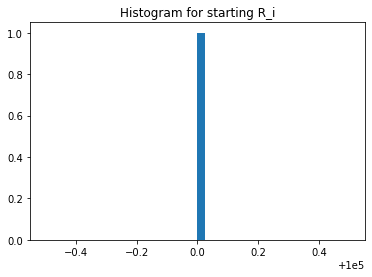

In [22]:
import matplotlib.pyplot as plt
a = starting_Ri.unique()
_ = plt.hist(a, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram for starting R_i")
plt.show()

In [23]:
experiments.UNI_Qi.unique()

array([200000., 199144., 196779., ..., 198530., 311230., 315133.])

In [24]:
experiments.UNI_Si.unique()

array([10000., 14904., 15009., 14928., 15075., 15234., 15118., 15062.,
       15026., 15055., 14984., 15050., 15069., 15015., 14878., 14993.,
       15028., 15049., 15115., 15020., 14988., 15027., 15080., 14999.,
       15092., 15000., 15041., 15258., 15148., 14961., 15067., 14830.,
       15024., 15105., 15186., 14966., 15097., 14985., 14955., 15205.,
       14867., 14886., 15037., 15108., 15007., 15156., 15052., 15031.,
       15124., 14840., 14880., 14990., 15145., 15214., 15081., 14957.,
       15014., 14986., 14952., 15184., 15177., 14977., 15128., 15003.,
       15138., 15023., 15136., 15199., 15178., 15259., 15113., 15209.,
       14989., 15150., 14981., 15072., 15254., 15114., 14900., 14948.,
       14888., 15123., 15018., 15109., 15117., 15157., 14918., 15001.,
       15076., 15271., 14967., 15227., 15043., 15240., 14958., 15065.,
       14983., 14913., 14902., 14953., 15131., 14853., 15101., 15035.,
       14869., 14997., 14881., 14960., 15172., 15011., 14912., 15094.,
      

In [25]:
experiments.UNI_Qj.unique()

array([200000., 197138., 195227., ..., 178440., 178864., 176655.])

In [26]:
experiments.UNI_Rj.unique()

array([100000., 101928., 102929., ..., 109859., 109275., 114482.])

In [27]:
starting_Rj = experiments[experiments.timestep == 0]
starting_Rj = starting_Rj['UNI_Rj']
starting_Rj.reset_index(drop=True)
starting_Rj.unique()

array([100000.])

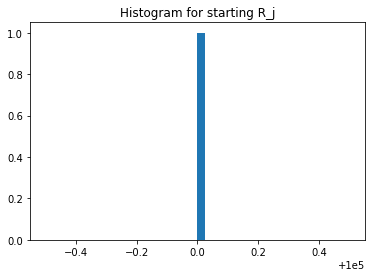

In [28]:
a = starting_Rj.unique()
_ = plt.hist(a, bins=40)  # arguments are passed to np.histogram
plt.title("Histogram for starting R_j")
plt.show()

In [29]:
experiments.UNI_Sj.unique()

array([10000])

In [30]:
experiments.UNI_ij.unique()

array([100000., 103349., 102377., ..., 113683.,  92013.,  92477.])

In [31]:
experiments.UNI_ji.unique()

array([100000.,  97312.,  98239., ...,  82826.,  83127.,  87131.])

In [32]:
experiments.UNI_Sij.unique()

array([1.e+10])

In [33]:
def get_M(k, v):
    if k == 'sim_config':
        k, v = 'M', v['M']
    return k, v

config_ids = [
    dict(
        get_M(k, v) for k, v in config.__dict__.items() if k in ['simulation_id', 'run_id', 'sim_config', 'subset_id']
    ) for config in configs
]

# Agent sequences

In [34]:
# agent_plot(experiment2,'Uniswap Token Holding for Agent ', 100) #,4,'j')

/home/mbarlin/.local/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


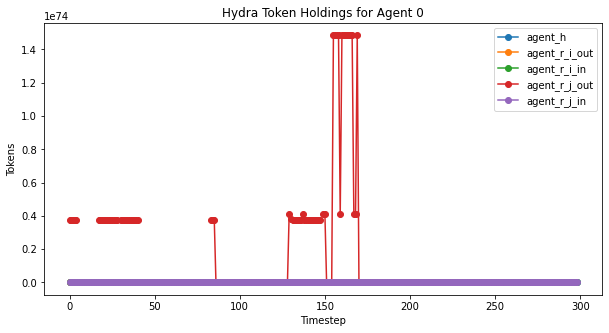

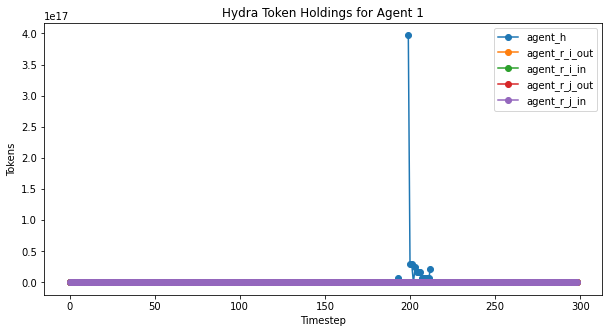

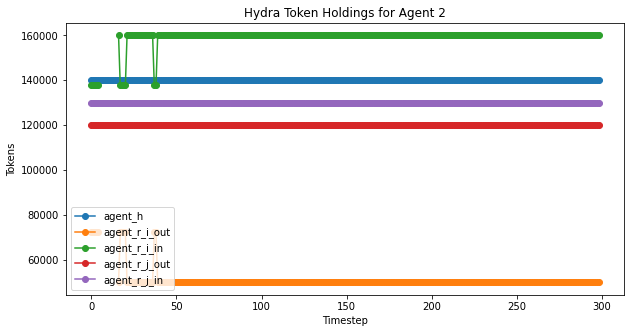

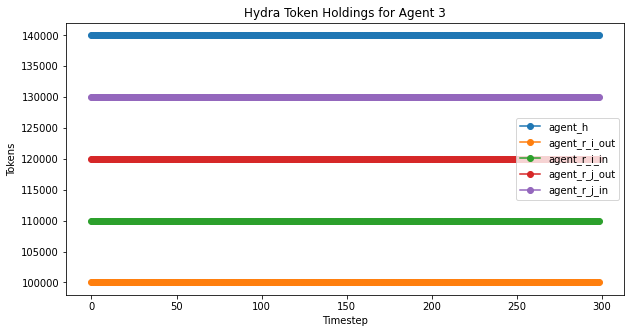

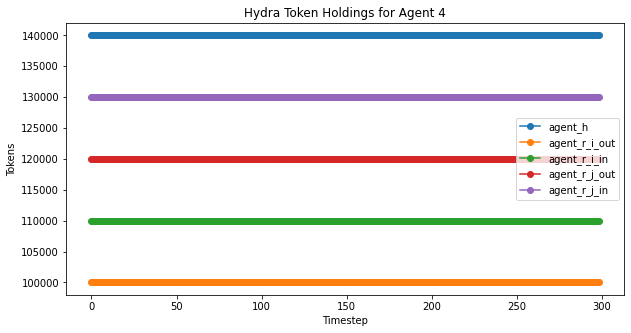

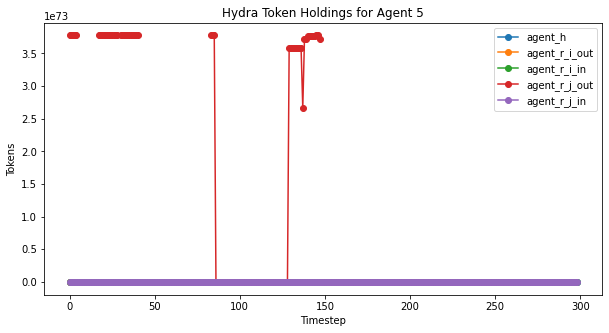

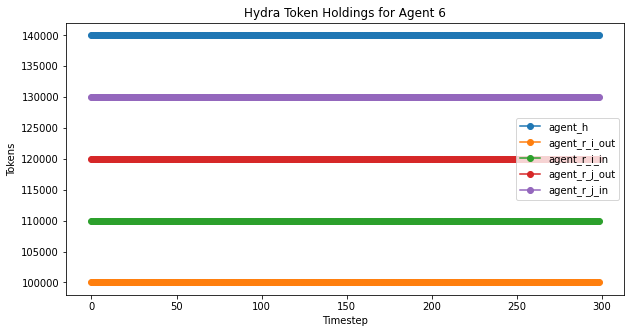

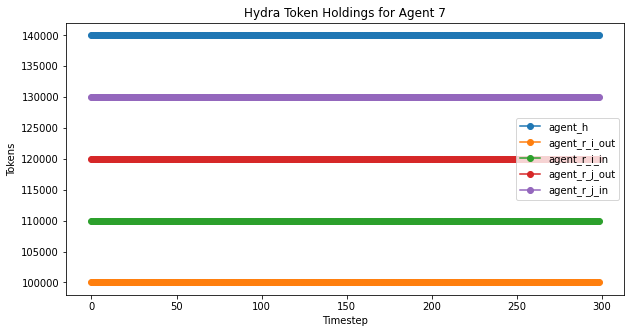

In [35]:
hydra_agent_plot(experiments,'Hydra Token Holdings for Agent ', 299)

# Liquidity dynamics

Movement of the Uniswap variables

- 'UNI_Ri', 'UNI_Qi', 'UNI_Si'
- 'UNI_Rj', 'UNI_Qj', 'UNI_Sj'
- 'UNI_ij', 'UNI_ji', 'UNI_Sij'

## Uniswap -- Ri-Q instance

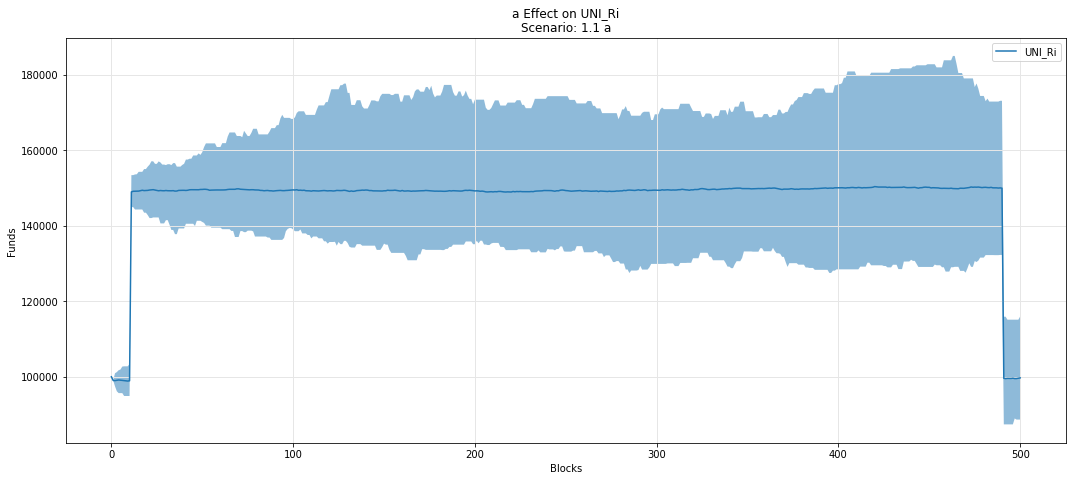

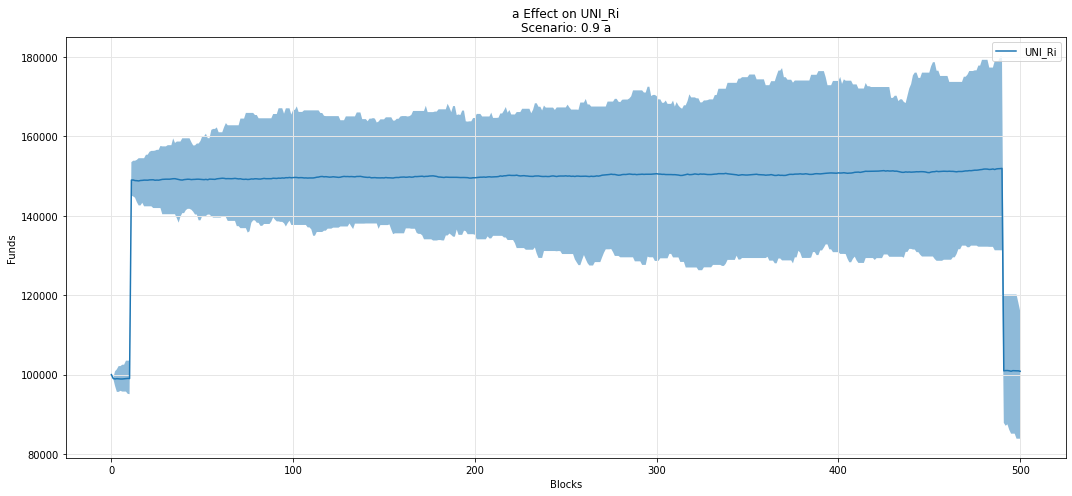

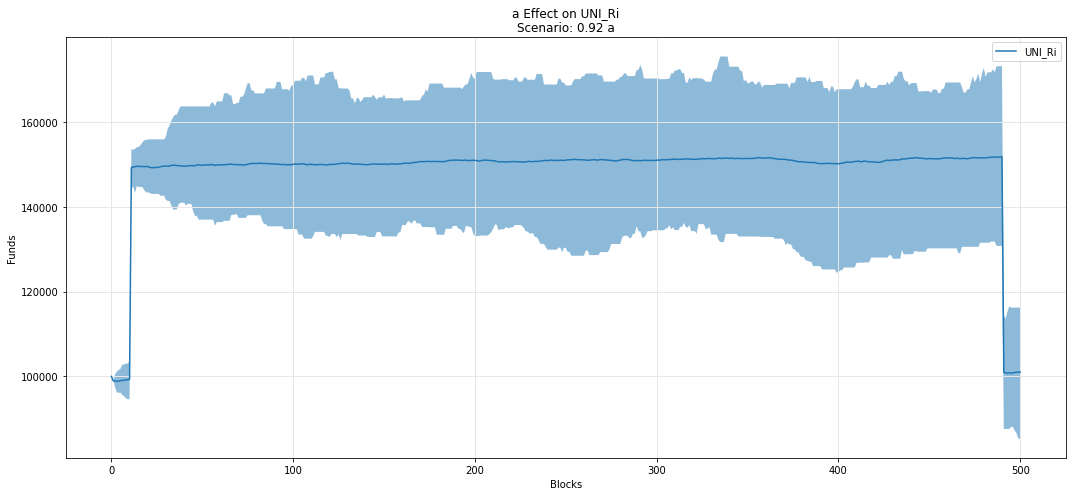

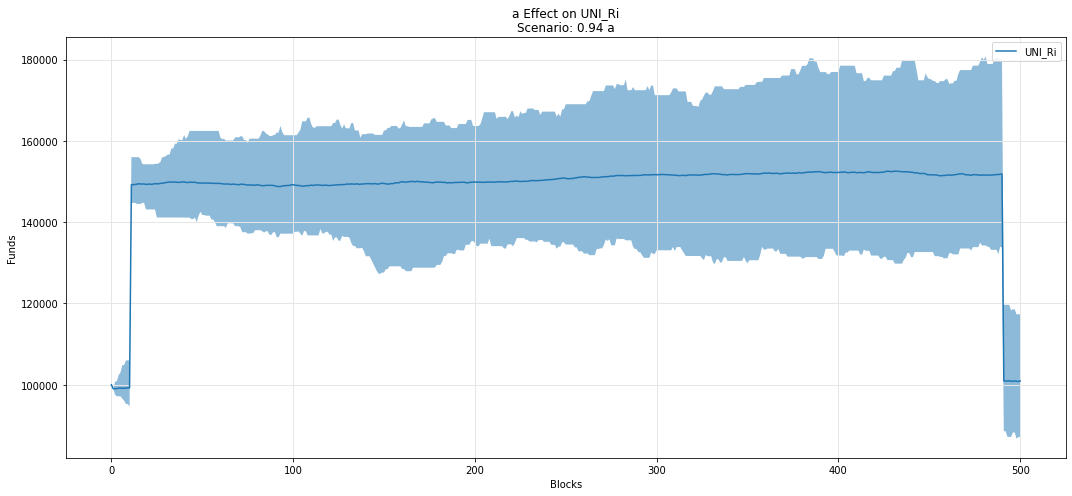

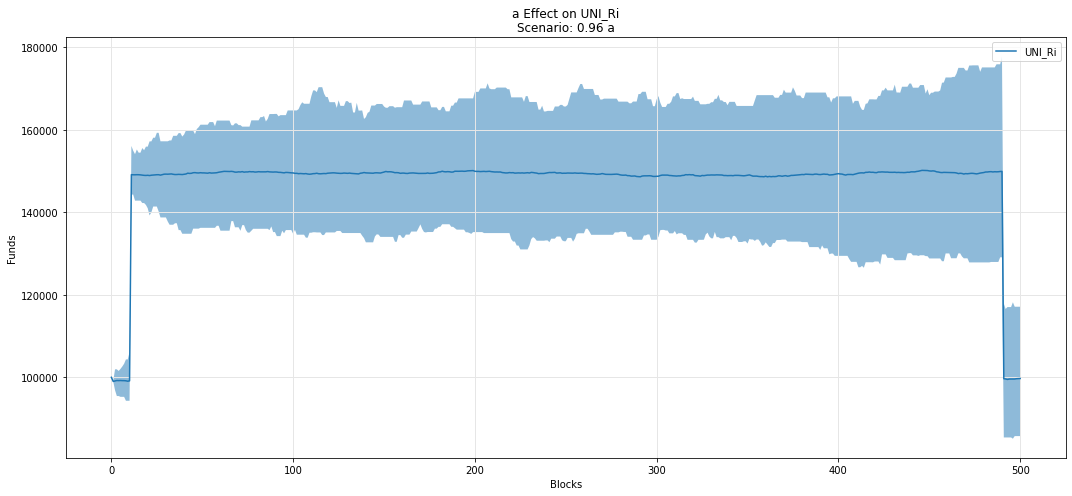

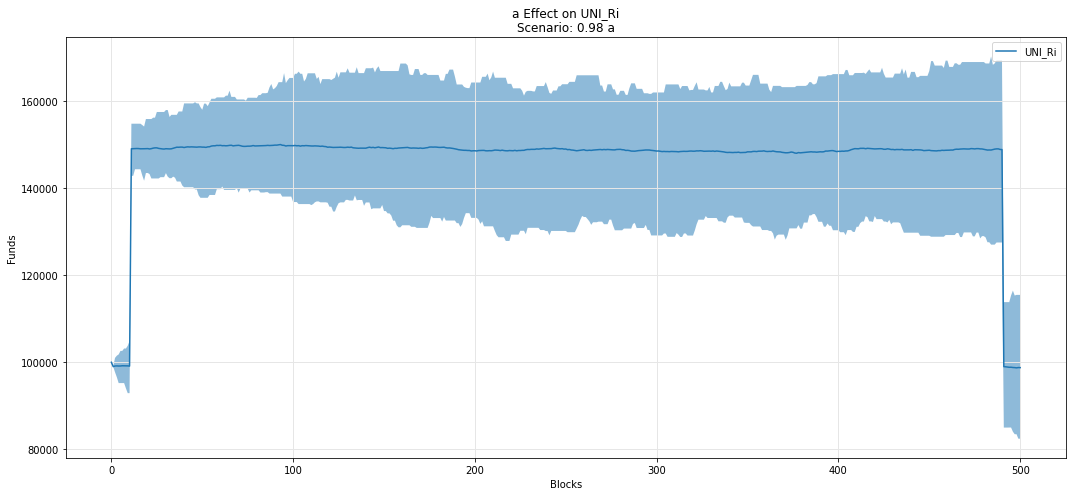

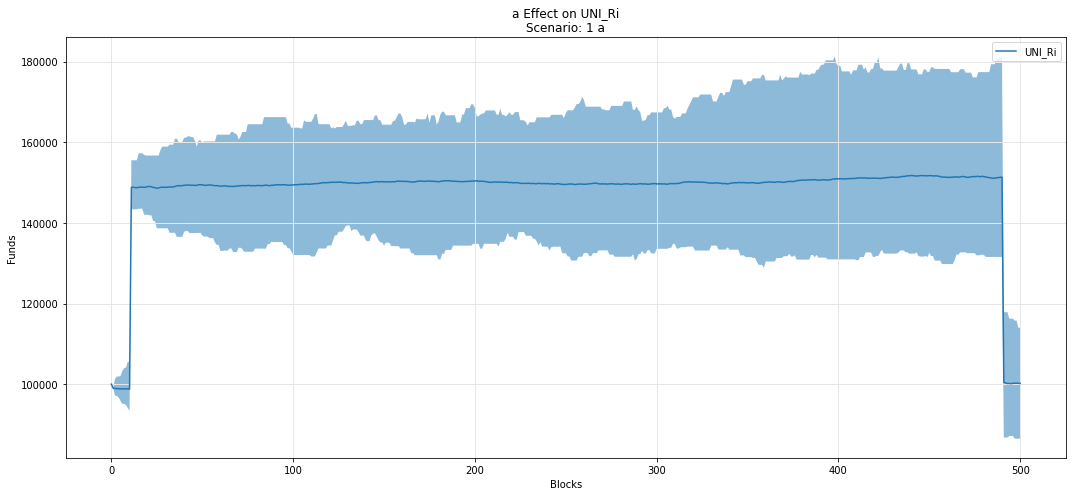

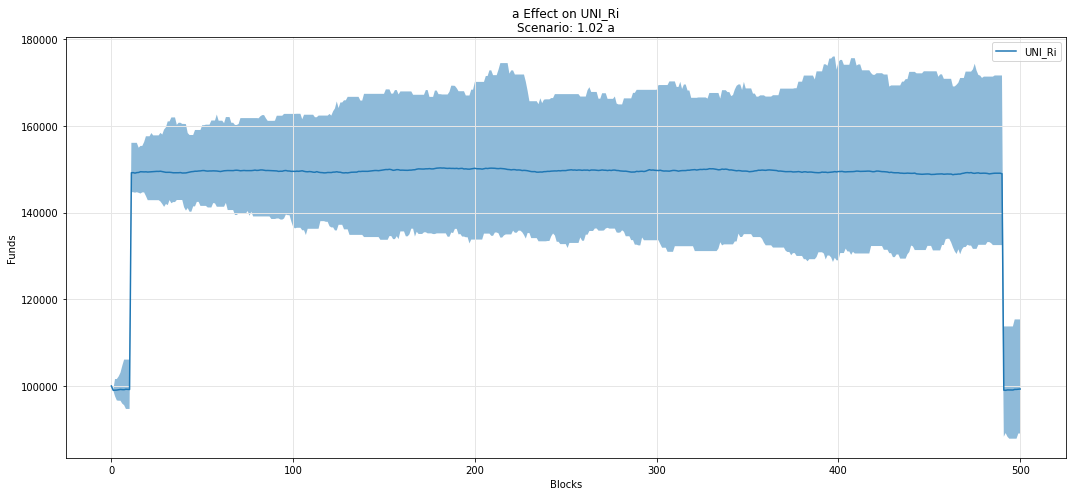

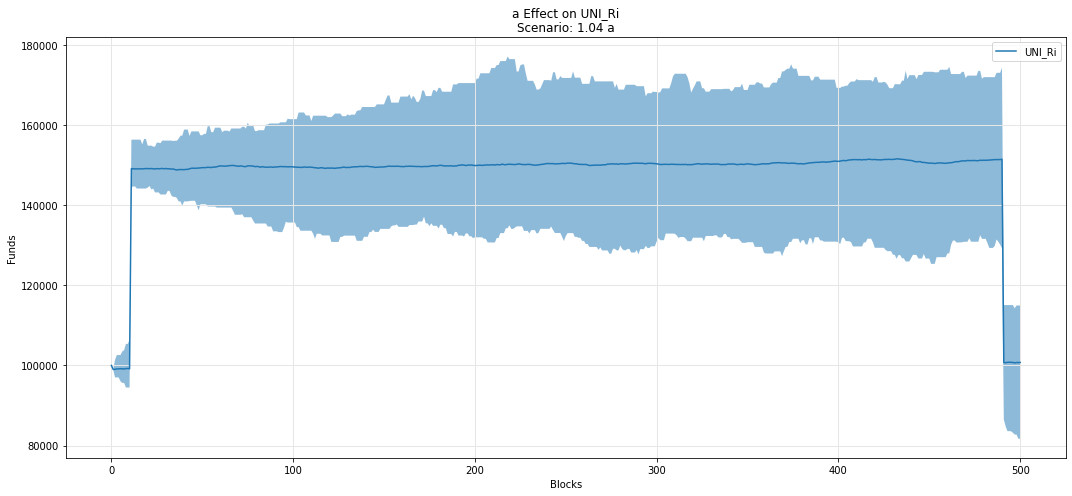

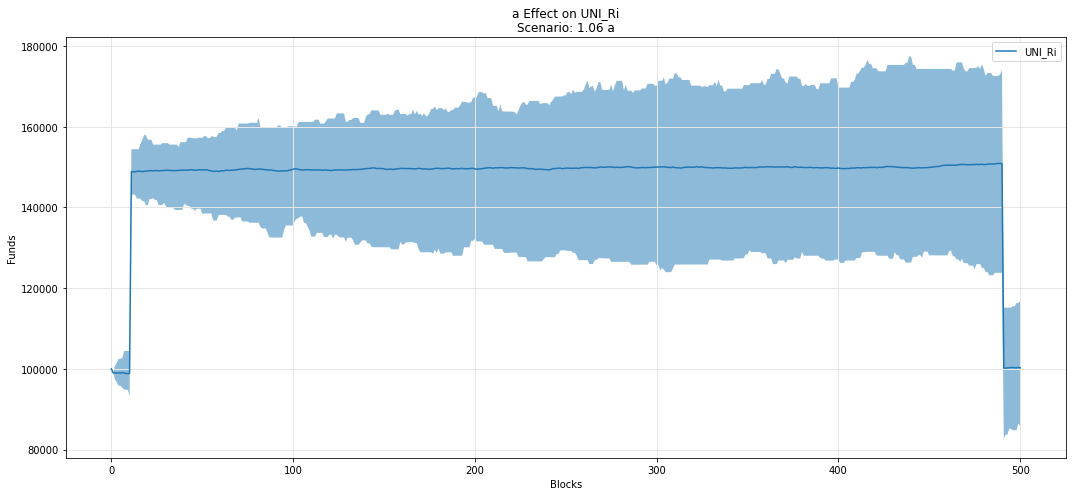

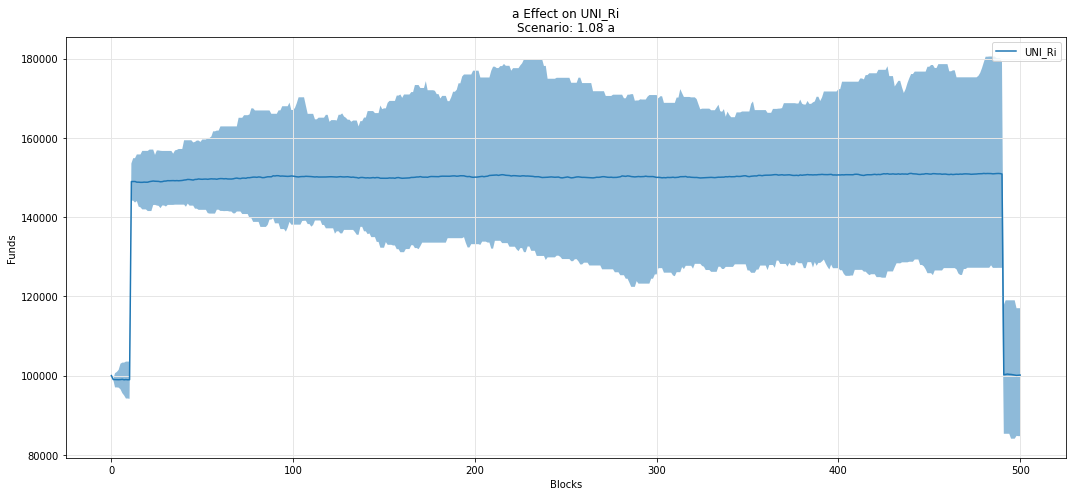

In [36]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Ri')

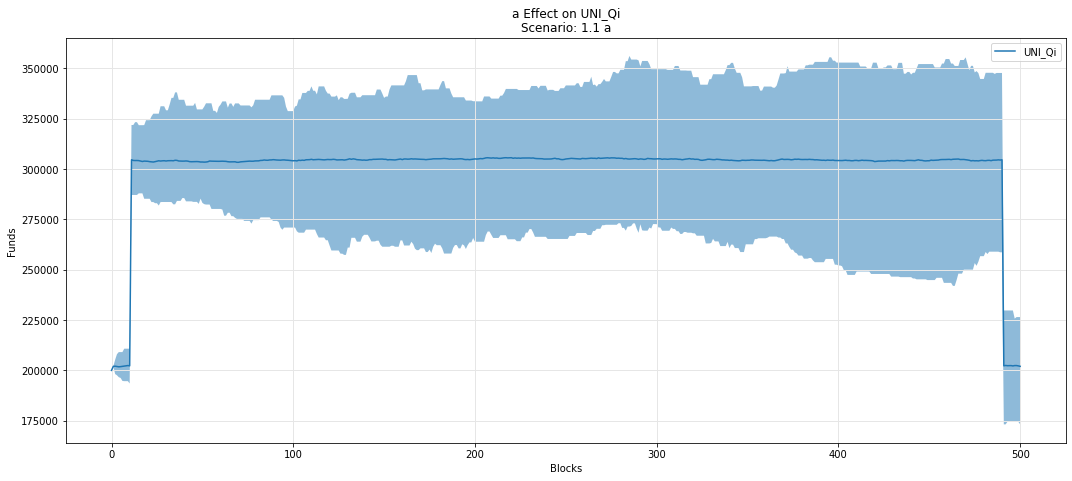

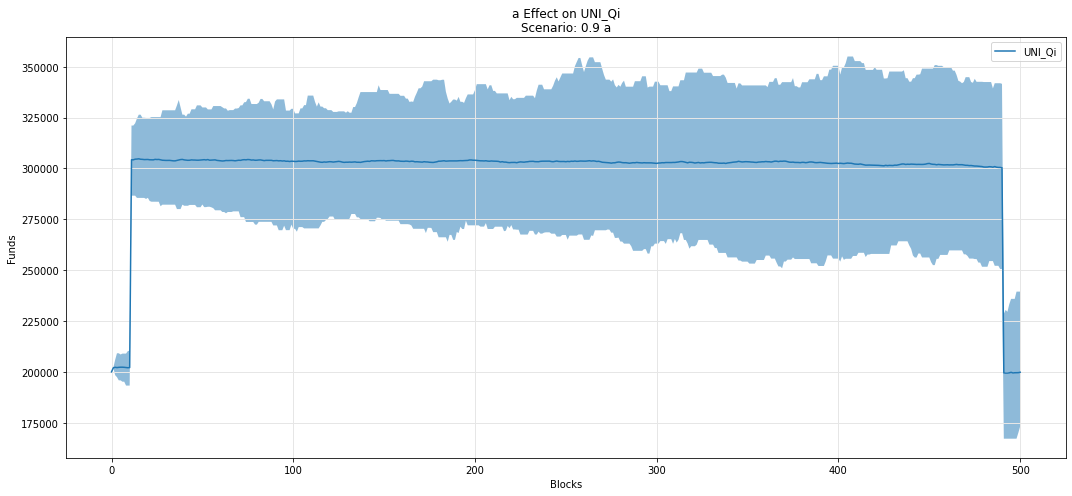

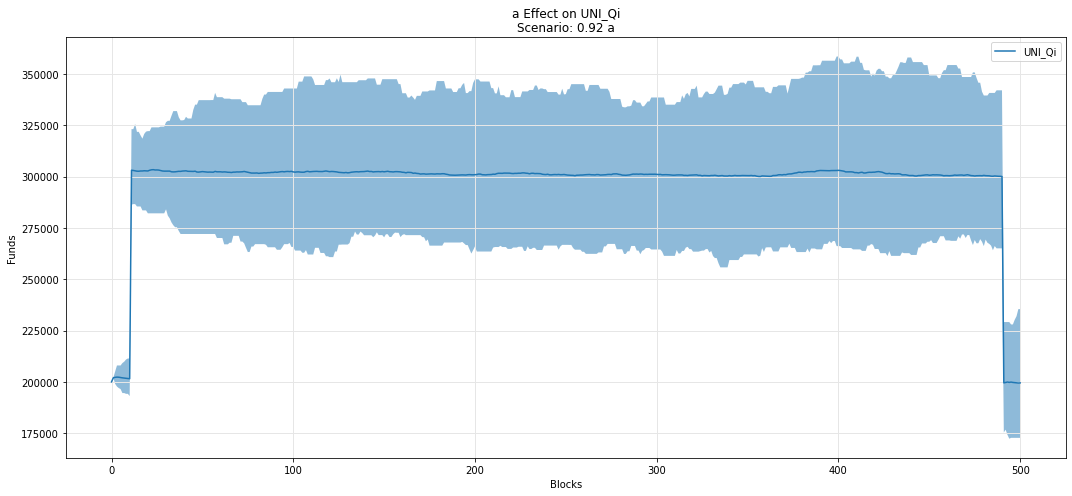

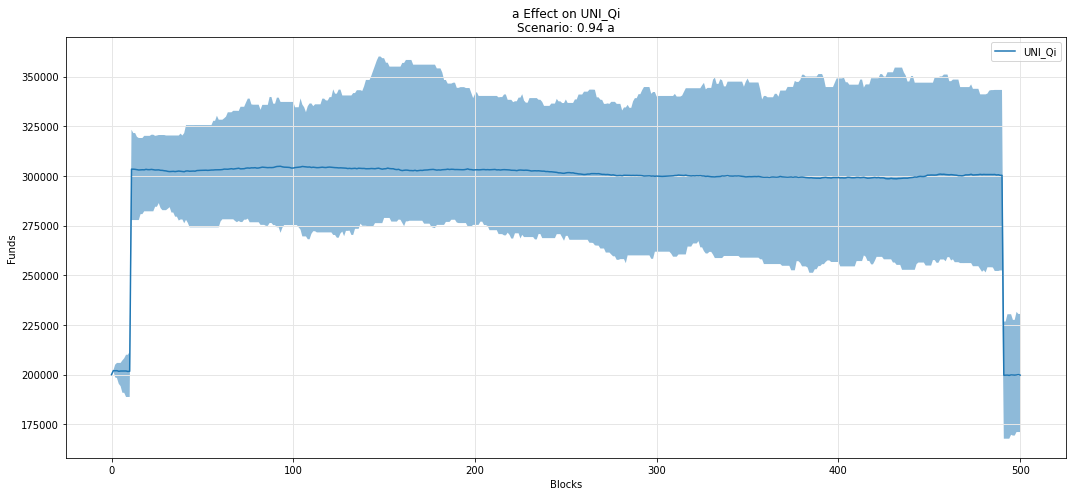

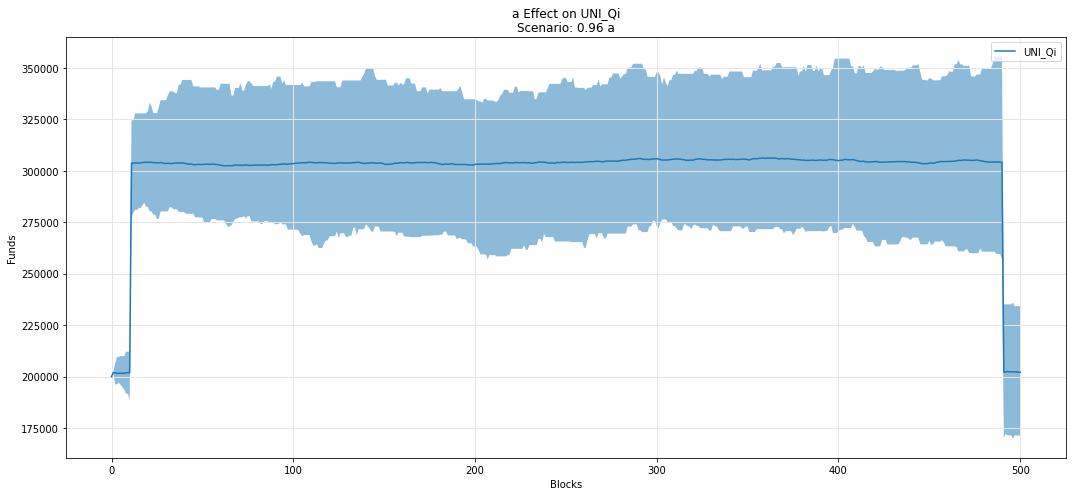

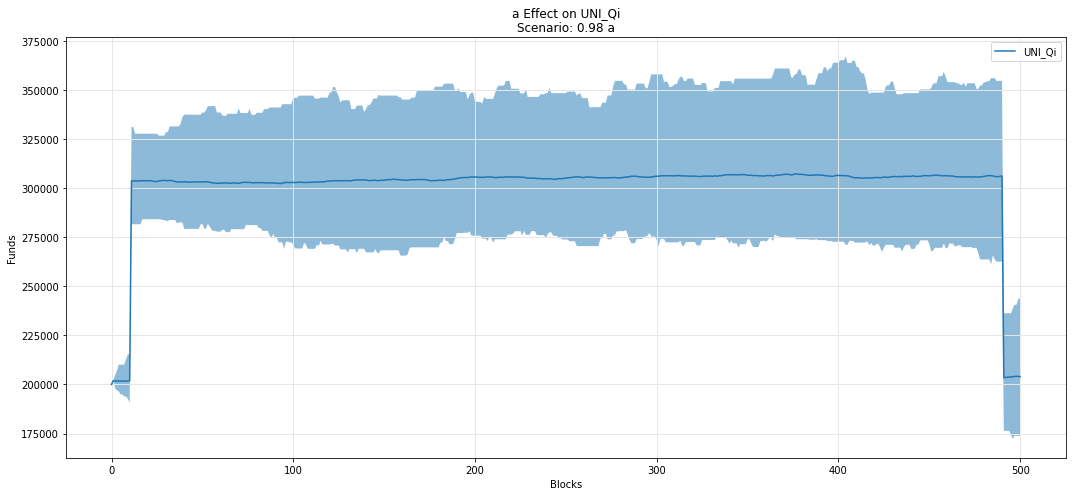

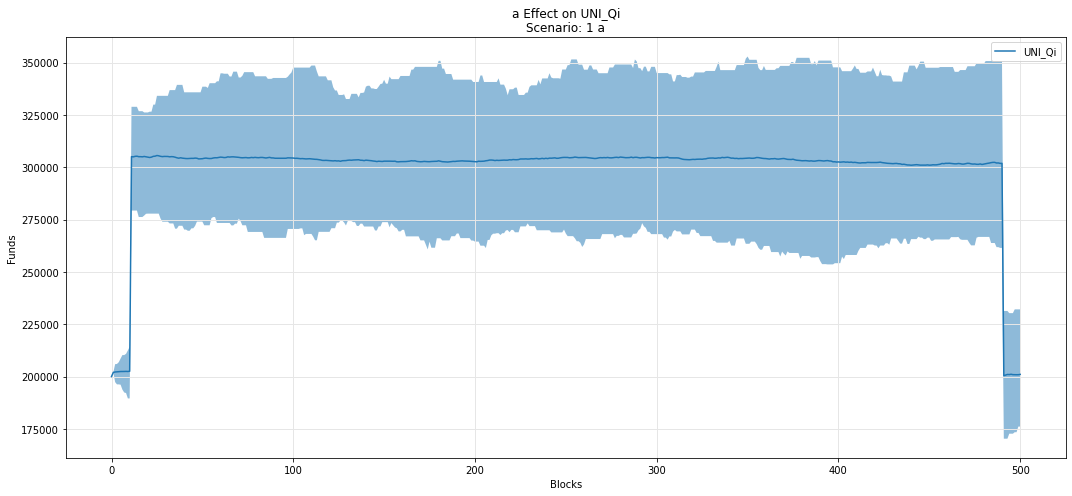

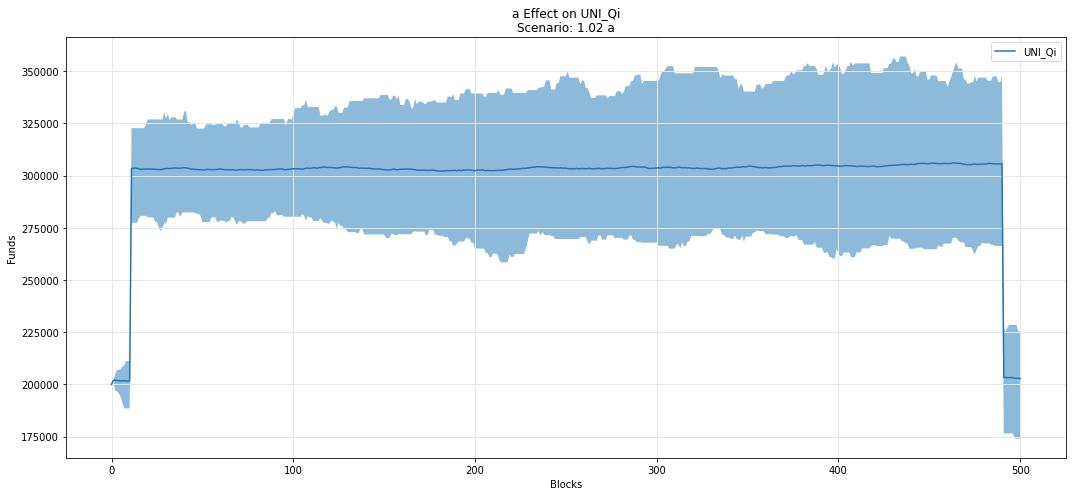

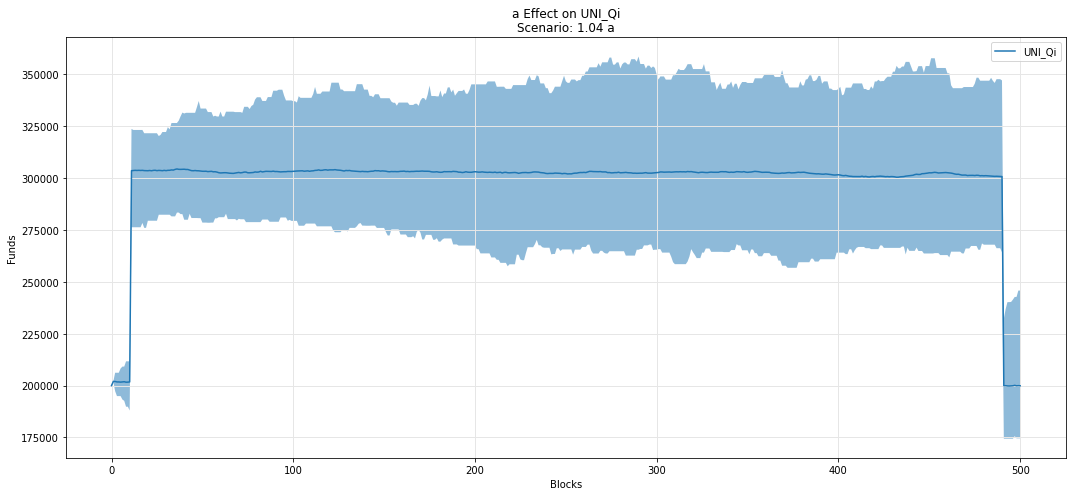

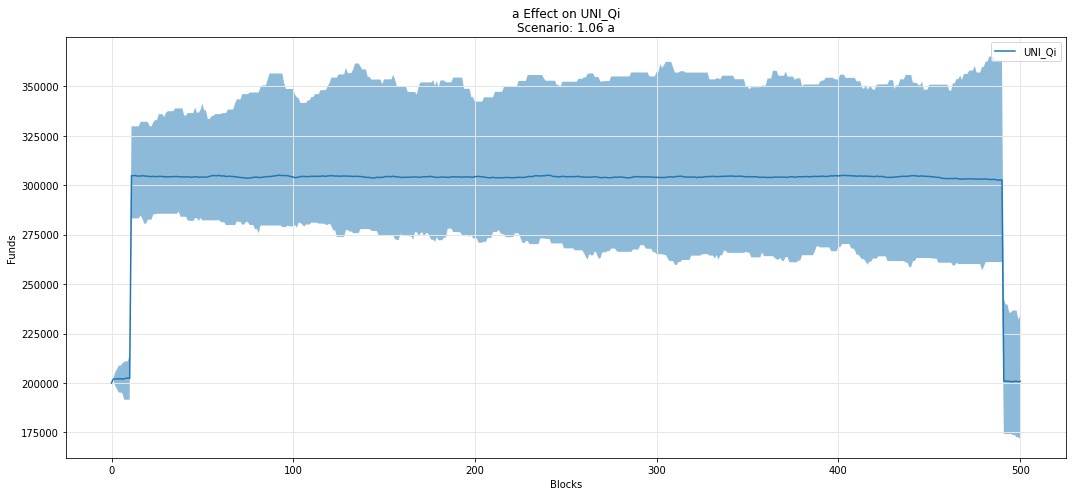

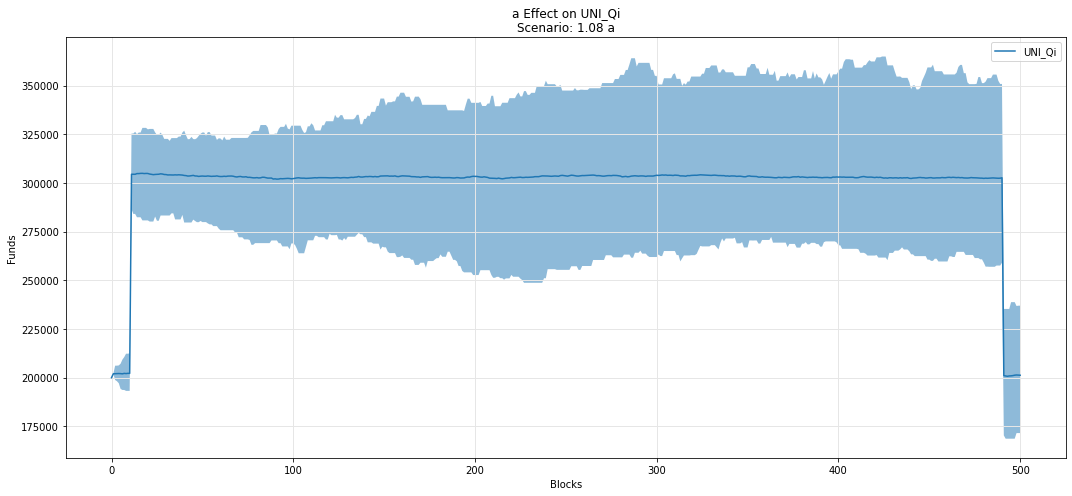

In [37]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Qi')

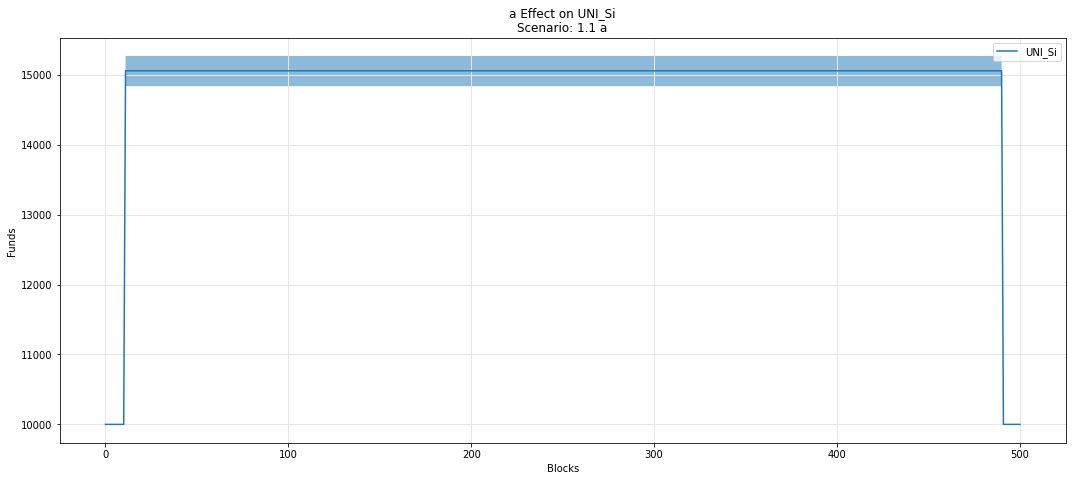

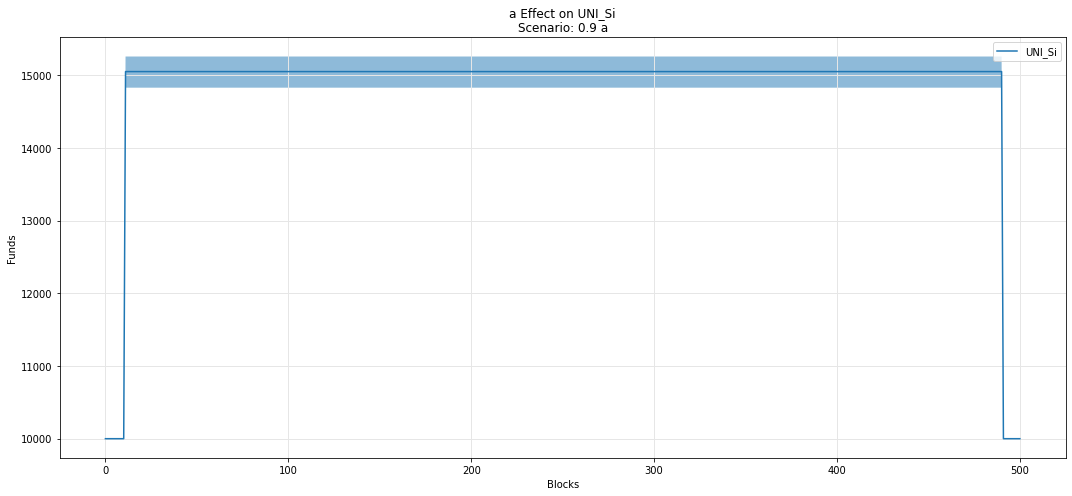

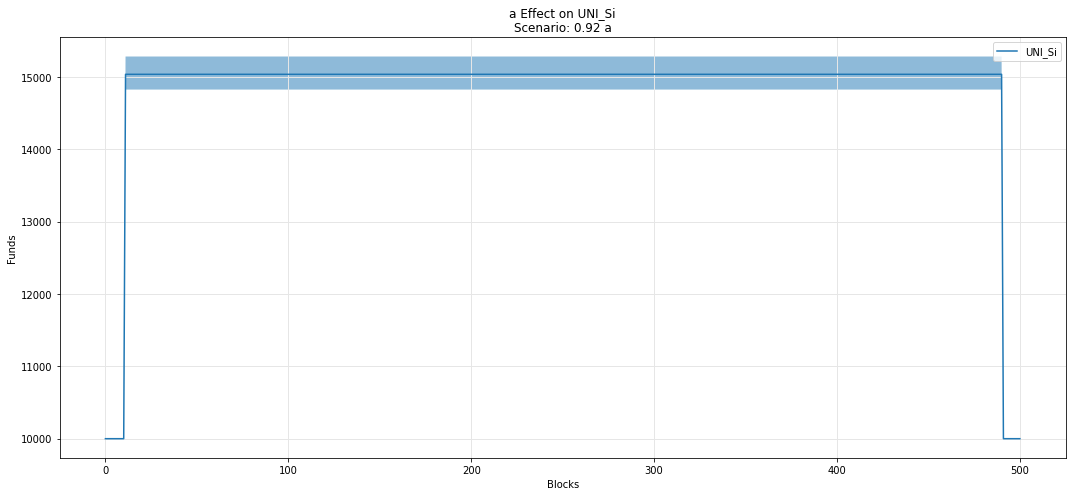

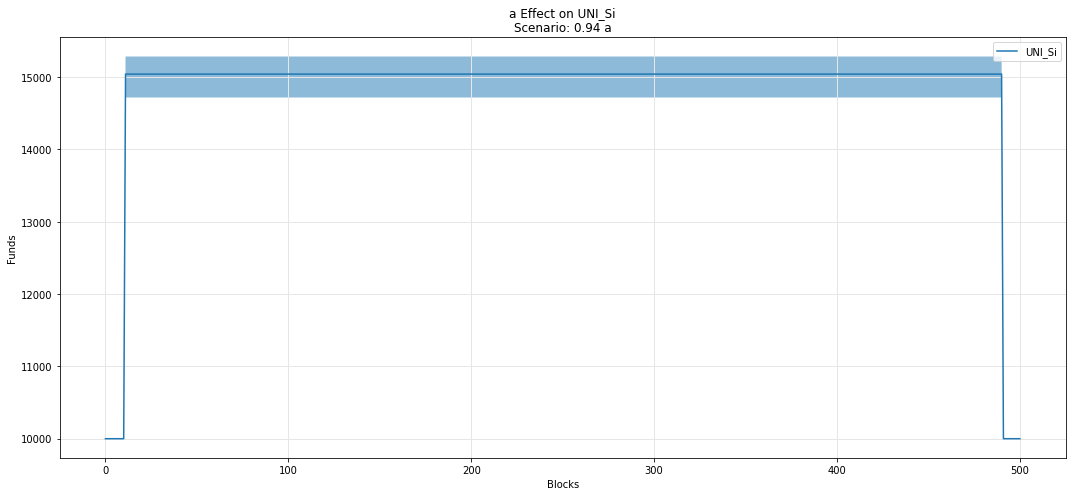

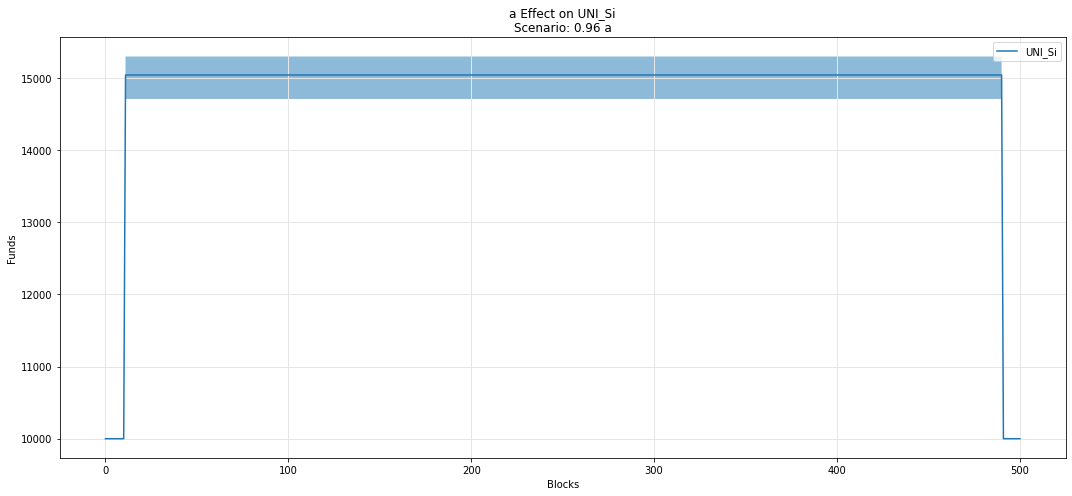

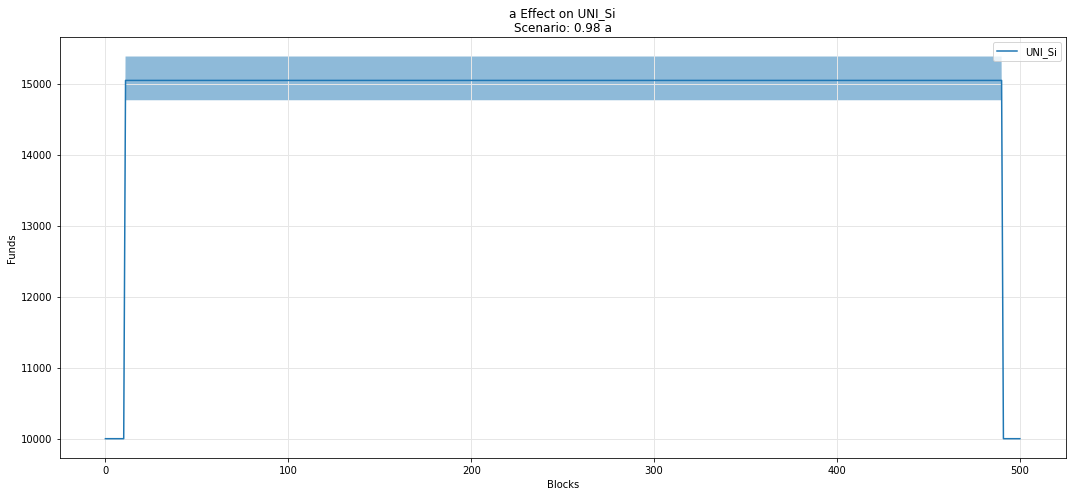

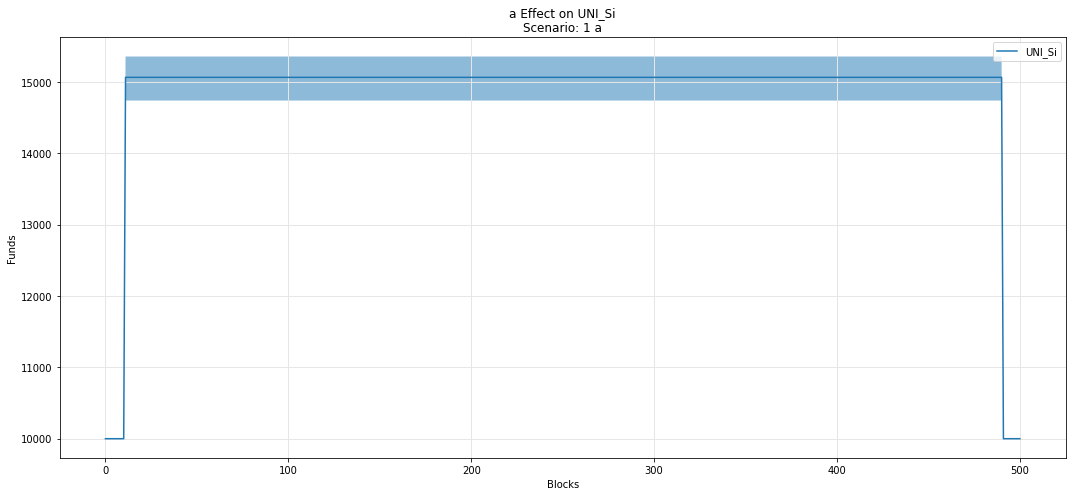

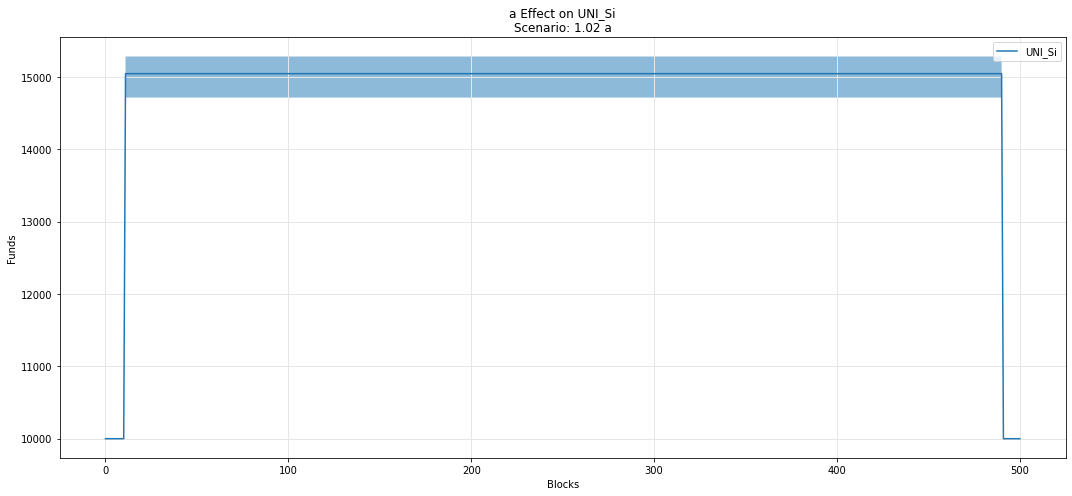

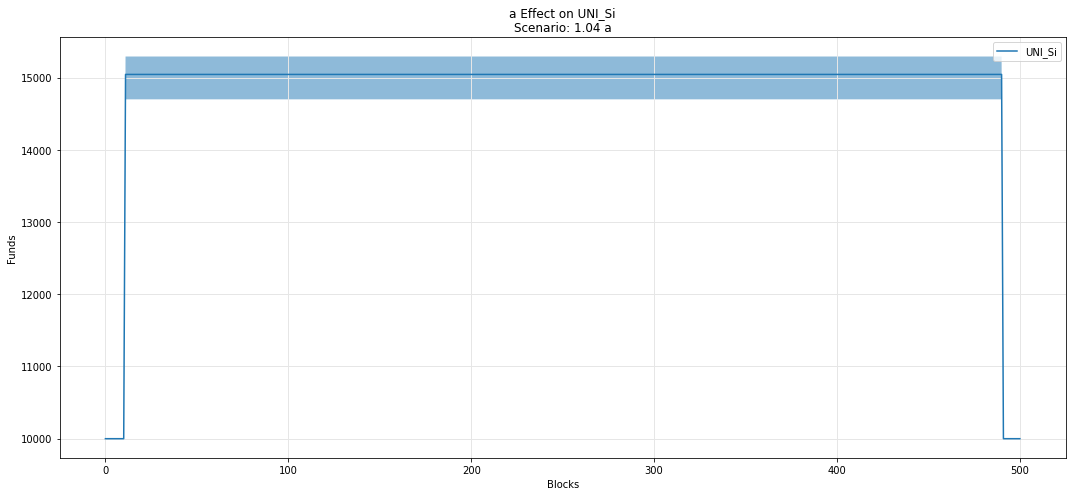

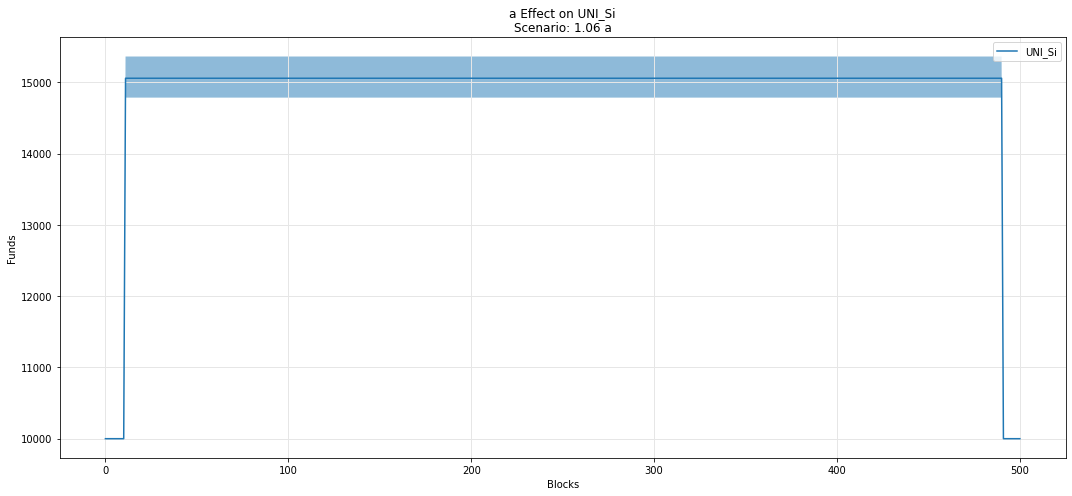

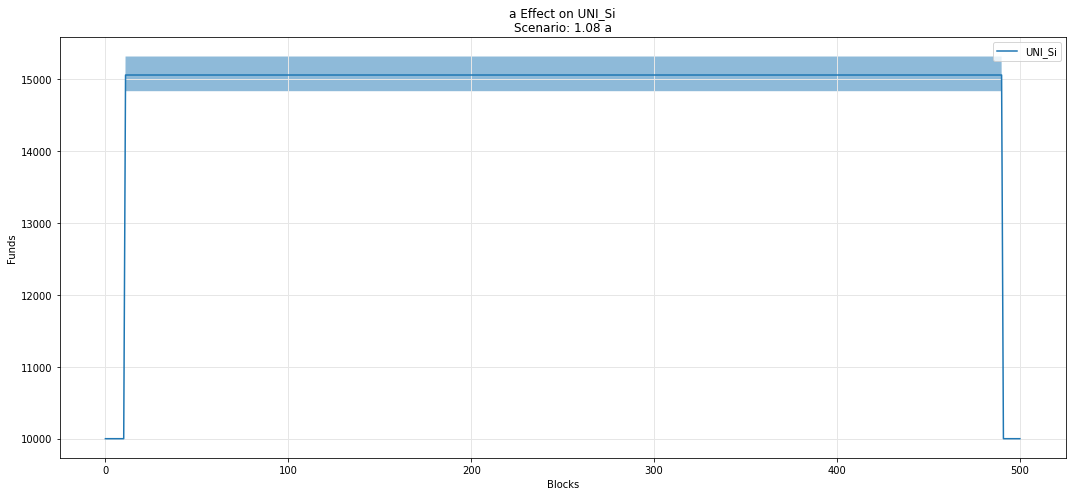

In [38]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Si')

## Uniswap -- Rj-Q instance

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Rj')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Qj')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Sj')

## Uniswap -- ij-Q instance

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','UNI_ij')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','UNI_ji')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','UNI_Sij')

## Hydra -- base

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','Q')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','H')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','Wq')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a','Sq')

## Hydra -- pool

Movement of the Omnipool variables
- Asset i
- Asset j
- Asset k

over the course of the simulation

In [ ]:
def param_pool_simulation_plot(experiments, config_ids, swept_variable, asset_id, y_variable, *args):
    """
    experiments is the simulation result dataframe.
    config_ids is the list configs executed upon in the simulation.
    swept_variable is the key (string) in config_ids that was being tested against.
    asset_id is the asset identifier in the pool (string) e.g i,j,k 
    y_variable is the state_variable (string) to be plotted against default timestep.

    *args for plotting more state_variables (string).
    """
    experiments = experiments.sort_values(by =['subset']).reset_index(drop=True)
    cols = 1
    rows = 1
    cc_idx = 0
    while cc_idx<len(experiments):
        cc = experiments.iloc[cc_idx]['subset']

        cc_label = experiments.iloc[cc_idx]['subset']

        secondary_label = [item['M'][swept_variable] for item in config_ids if  item["subset_id"]== cc_label]
        sub_experiments = experiments[experiments['subset']==cc]
        cc_idx += len(sub_experiments)
        fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15*cols,7*rows))

        df = sub_experiments.copy()

        df_label = y_variable + asset_id
        df[df_label] = df.pool.apply(lambda x: np.array(x.pool[asset_id][y_variable]))
        colors = ['orange', 'g', 'magenta', 'r', 'k' ]
        df = df.groupby('timestep').agg({df_label: ['min', 'mean', 'max']}).reset_index()
        ax = axs
        title = swept_variable + ' Effect on Pool Asset ' + asset_id + '\n' + 'Scenario: ' + str(secondary_label[0]) + ' ' + swept_variable
        # + 'Scenario: ' + str(cc_label)  + ' rules_price'
        ax.set_title(title)
        ax.set_ylabel('Funds')

        df.plot(x='timestep', y=(df_label,'mean'), label=df_label, ax=ax, legend=True, kind ='scatter')
        ax.fill_between(df.timestep, df[(df_label,'min')], df[(df_label,'max')], alpha=0.3)    
        for count, arg in enumerate(args):
            df = sub_experiments.copy()
            
            df_arg_label = arg + asset_id
            df[df_arg_label] = df.pool.apply(lambda x: np.array(x.pool[asset_id][arg]))
            df = df.groupby('timestep').agg({df_arg_label: ['min', 'mean', 'max']}).reset_index()

            df.plot(x='timestep', y=(df_arg_label,'mean'), label=df_arg_label, ax=ax, legend=True, color = colors[count], kind ='scatter')
            ax.fill_between(df.timestep, df[(df_arg_label,'min')], df[(df_arg_label,'max')], alpha=0.3)    

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        ax.set_xlabel('Timesteps')
        ax.grid(color='0.9', linestyle='-', linewidth=1)

        plt.tight_layout()
            
    fig.tight_layout(rect=[0, 0, 1, .97])
    fig.patch.set_alpha(1)
    plt.close()
    return display(fig)

In [ ]:
param_pool_simulation_plot(experiments, config_ids, 'a','i', 'R', 'S', 'W')

In [ ]:
param_pool_simulation_plot(experiments, config_ids, 'a','j', 'R', 'S', 'W')

In [ ]:
param_pool_simulation_plot(experiments, config_ids, 'a','k', 'R', 'S', 'W')

In [ ]:
def param_pool_simulation_plot(experiments, config_ids, swept_variable, asset_id, y_variable, *args):
    """
    experiments is the simulation result dataframe.
    config_ids is the list configs executed upon in the simulation.
    swept_variable is the key (string) in config_ids that was being tested against.
    asset_id is the asset identifier in the pool (string) e.g i,j,k 
    y_variable is the state_variable (string) to be plotted against default timestep.

    *args for plotting more state_variables (string).
    """
    experiments = experiments.sort_values(by =['subset']).reset_index(drop=True)
    cols = 1
    rows = 1
    cc_idx = 0
    while cc_idx<len(experiments):
        cc = experiments.iloc[cc_idx]['subset']

        cc_label = experiments.iloc[cc_idx]['subset']

        secondary_label = [item['M'][swept_variable] for item in config_ids if  item["subset_id"]== cc_label]
        sub_experiments = experiments[experiments['subset']==cc]
        cc_idx += len(sub_experiments)
        fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15*cols,7*rows))

        df = sub_experiments.copy()

        df_label = y_variable + asset_id
        df[df_label] = df.pool.apply(lambda x: np.array(x.pool[asset_id][y_variable]))
        colors = ['orange', 'g', 'magenta', 'r', 'k' ]
        df = df.groupby('timestep').agg({df_label: ['min', 'mean', 'max']}).reset_index()
        ax = axs
        title = swept_variable + ' Effect on Pool Asset ' + asset_id + '\n' + 'Scenario: ' + str(secondary_label[0]) + ' ' + swept_variable
        # + 'Scenario: ' + str(cc_label)  + ' rules_price'
        ax.set_title(title)
        ax.set_ylabel('Funds')

        df.plot(x='timestep', y=(df_label,'mean'), label=df_label, ax=ax, legend=True, kind ='scatter')
        ax.fill_between(df.timestep, df[(df_label,'min')], df[(df_label,'max')], alpha=0.3)    
        for count, arg in enumerate(args):
            df = sub_experiments.copy()
            
            df_arg_label = arg + asset_id
            df[df_arg_label] = df.pool.apply(lambda x: np.array(x.pool[asset_id][arg]))
            df = df.groupby('timestep').agg({df_arg_label: ['min', 'mean', 'max']}).reset_index()

            df.plot(x='timestep', y=(df_arg_label,'mean'), label=df_arg_label, ax=ax, legend=True, color = colors[count], kind ='scatter')
            ax.fill_between(df.timestep, df[(df_arg_label,'min')], df[(df_arg_label,'max')], alpha=0.3)    

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        ax.set_xlabel('Timesteps')
        ax.grid(color='0.9', linestyle='-', linewidth=1)

        plt.tight_layout()
            
    fig.tight_layout(rect=[0, 0, 1, .97])
    fig.patch.set_alpha(1)
    plt.close()
    return display(fig)

# Prices

## Uniswap

In [ ]:
param_fan_plot3(experiments, config_ids, 'a', 'UNI_P_RQi')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a', 'UNI_P_RQj')

In [ ]:
param_fan_plot3(experiments, config_ids, 'a', 'UNI_P_ij')

## Omnipool

## Asset i

In [ ]:
param_pool_simulation_plot(experiments, config_ids, 'a','i','P')

## Asset j

In [ ]:
param_pool_simulation_plot(experiments, config_ids, 'a','j','P')

## Asset k

In [ ]:
param_pool_simulation_plot(experiments, config_ids, 'a','k','P')